# Redsim Demo

#### Maria Silva, February 2024


## Overview

Redsim is a simulation framework that forecasts a set of metrics related to the revenue and the cost of running Redstone's Sequencer. In redsim, we call these metrics **operation metrics** and they are derived by the combination of two key components:

- A set of [random variables](https://en.wikipedia.org/wiki/Random_variable) that encode user decisions and market conditions, which we call **market variables**. Each market variable has a standard distribution, picked from an empirical exploration of real data. We can change the parameters of their distributions (e.g. mean and standard deviation) to encode different scenarios of user behavior and market conditions. We call these parameters **market parameters** and redsim receives them as input.
- A set of deterministic formulas that compute the operation metrics from market variables and a set of additional parameters. These parameters encode key specifications such as the simulation length and Redstone's protocol parameters. We call them **simulation parameters** and **protocol parameters**, respectively. They are also received as inputs by redsim.

Redsim is based on the [Monte-Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) (MC) method. It generates random samples from the market variables and, for each sample combination, it calculates the corresponding operation metrics.

For more information on the simulation framework and its specifications, please refer to [Redsim's Model Specs](https://hackmd.io/@nightingale/redstone-gas/%2F5X5ssL9mToq7D9y2iFOFXA).

## Load & imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

In [3]:
from redsim.params import Params
from redsim.sim import run_mc_sim, compute_output_aggregate

## Parameter walkthrough

**Simulation parameters**: these are parameters that control the simulation specs. They include:
- `sim_len`: the number of Ethereum blocks forecasted by the simulation (i.e. simulation length)
- `sim_iter`: number of Monte-Carlo samples to generate

In [4]:
sim_len = int(15 * 60 * 60 * 24 / 12)  # 15 day of ETH blocks
sim_iter = 100  # MC paths

For the remaining parameters, `redsim` offers a default setting:

In [5]:
params = Params()
params.set_default_params()

Let's start by looking at the protocol parameters. They include:
- L2 gas fees:
  - `l1_fee_overhead`
  - `l1_fee_scalar`
- Batcher:
  - `max_channel_duration` (unit = number of l1 blocks)
  - `batcher_target_size` (unit = gas units)
  - `batcher_est_compr_ratio`
- Proposer:
    - `submission_interval` (unit = number of l1 blocks)
- DA resolver:
    - `resolver_refund_factor`
 
The default values for these parameters are:

In [6]:
params.get_protocol_params()

{'l1_fee_overhead': 2100.0,
 'l1_fee_scalar': 100000.0,
 'max_channel_duration': 6,
 'batcher_target_size': 1600000.0,
 'batcher_est_compr_ratio': 0.4,
 'submission_interval': 300,
 'resolver_refund_factor': 0.0}

Next, we have the market parameters, which encode different scenarios of user behavior and market conditions. They include:
- L1 base fees distribution:
    - `l1_base_fee_shape`: the `shape` parameter for the Gamma distribution
    - `l1_base_fee_loc`: the `loc` parameter for the Gamma distribution
    - l1_base_fee_scale`: The `scale` parameter for the Gamma distribution
- L1 priority fees distribution:
    - `l1_prio_shape`: the `shape` parameter for the Gamma distribution
    - `l1_prio_scale`: the `scale` parameter for the Gamma distribution
- L2 base fees distribution:
    - `l2_base_shape`: the `shape` parameter for the Gamma distribution
    - `l2_base_scale`: the `scale` parameter for the Gamma distribution
- L2 priority fees distribution:
    - `l2_prio_shape`: the `shape` parameter for the Gamma distribution
    - `l2_prio_scale`: the `scale` parameter for the Gamma distribution
- L2 gas usage distribution:
    - `gas_use_low_threshold`: gas units that separate the low-value group from the high-value group
    - `gas_use_low_prob`: the probability of sampling a low-value gas usage (<`gas_use_low_threshold` units)
    - `gas_use_low_mu`: average gas usage for low-value samples (<`gas_use_low_threshold` units)
    - `gas_use_low_sigma`: standard deviation of gas usage for low-value samples (<`gas_use_low_threshold` units)
    - `gas_use_high_shape`: the `shape` parameter for the Gamma distribution
    - `gas_use_high_loc`: the `loc` parameter for the Gamma distribution
    - `gas_use_high_scale`: The `scale` parameter for the Gamma distribution
- DA challenges distribution:
    - `da_chalenge_p`: probability of an input commitment from the batcher having a DA challenge
- Infra costs distribution:
    - `infra_costs_mu`: average infra costs
    - `infra_costs_sigma`: standard deviation of infra costs
- `compress_ratio`: the data compression ratio on Redstone
- `batcher_commit_size` (unit = gas units): gas units used by Redstone's Batcher to post input commitments
- `proposer_commit_size` (unit = gas units): gas units used by Redstone's Proposer to post state commitments
- `eth_price_usd`: price of ETH in USD

The default values for these parameters are:

In [7]:
params.get_market_params()

{'l1_base_fee_shape': 1.8,
 'l1_base_fee_loc': 6.3,
 'l1_base_fee_scale': 11.4,
 'l1_prio_shape': 0.0002,
 'l1_prio_scale': 80.0,
 'l2_base_shape': 0.5,
 'l2_base_scale': 0.044,
 'l2_prio_shape': 3.2e-05,
 'l2_prio_scale': 1.5,
 'gas_use_low_prob': 0.76,
 'gas_use_low_threshold': 350000,
 'gas_use_low_mu': 301000,
 'gas_use_low_sigma': 6685,
 'gas_use_high_shape': 0.06,
 'gas_use_high_loc': 350000.0,
 'gas_use_high_scale': 7200000.0,
 'da_chalenge_p': 0.0007,
 'compress_ratio': 0.4,
 'batcher_commit_size': 21500.0,
 'proposer_commit_size': 90900.0,
 'infra_costs_mu': 0.047,
 'infra_costs_sigma': 0.01,
 'eth_price_usd': 2500.0}

We can change the default value of a particular parameter by using the `set_param` function:

In [8]:
params.set_param("eth_price_usd", 2800.0)
params.get_param("eth_price_usd")

2800.0

## Run Monte-Carlo simulation - default params

Now, to run an MC simulation with a single set of parameters, we can use the `run_mc_sim` function:

In [9]:
mc_df = run_mc_sim(sim_len, sim_iter, params)
mc_df.info()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.61it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800000 entries, 0 to 10799999
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   timestamp              datetime64[ns]
 1   onchain_profit_eth     float64       
 2   onchain_profit_usd     float64       
 3   total_profit_eth       float64       
 4   total_profit_usd       float64       
 5   op_rev_share_cost_eth  float64       
 6   l1_base_fee_gwei       float64       
 7   l1_prio_fee_gwei       float64       
 8   l2_base_fee_gwei       float64       
 9   l2_prio_fee_gwei       float64       
 10  l2_gas                 float64       
 11  da_challenge           int64         
 12  infra_cost_usd         float64       
 13  revenue_eth            float64       
 14  revenue_data_eth       float64       
 15  revenue_exec_eth       float64       
 16  onchain_cost_eth       float64       
 17  proposer_gas_cost_eth  float64       
 18  da_gas_cost_eth     

We can make the data analysis simpler by transforming the data into daily aggregates:

In [10]:
agg_mc_df = compute_output_aggregate(mc_df, "D", ["iter"])
agg_mc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   timestamp              1500 non-null   datetime64[ns]
 1   iter                   1500 non-null   int64         
 2   onchain_profit_eth     1500 non-null   float64       
 3   onchain_profit_usd     1500 non-null   float64       
 4   total_profit_eth       1500 non-null   float64       
 5   total_profit_usd       1500 non-null   float64       
 6   op_rev_share_cost_eth  1500 non-null   float64       
 7   l1_base_fee_gwei       1500 non-null   float64       
 8   l1_prio_fee_gwei       1500 non-null   float64       
 9   l2_base_fee_gwei       1500 non-null   float64       
 10  l2_prio_fee_gwei       1500 non-null   float64       
 11  l2_gas                 1500 non-null   float64       
 12  da_challenge           1500 non-null   float64       
 13  inf

And we can we explore the results:

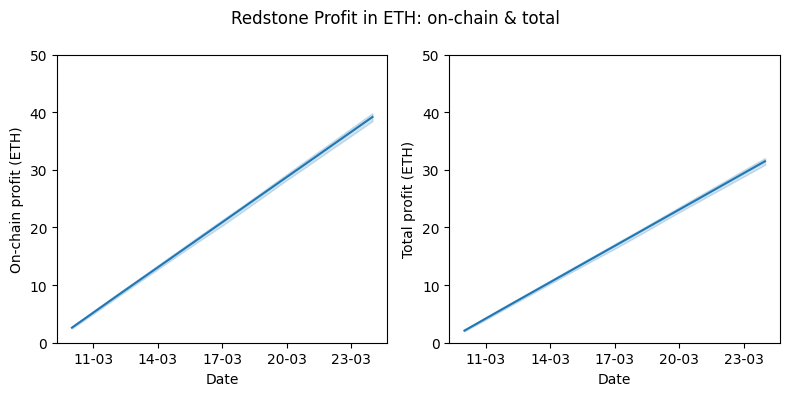

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
sns.lineplot(data=agg_mc_df, x="timestamp", y="onchain_profit_eth", errorbar="pi", ax=axs[0])
axs[0].set_xlabel("Date") 
axs[0].set_ylabel("On-chain profit (ETH)") 
axs[0].set_ylim(0,50)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=3))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
sns.lineplot(data=agg_mc_df, x="timestamp", y="total_profit_eth", errorbar="pi", ax=axs[1])
axs[1].set_xlabel("Date") 
axs[1].set_ylabel("Total profit (ETH)") 
axs[1].set_ylim(0,50)
plt.suptitle("Redstone Profit in ETH: on-chain & total")
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=3))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.tight_layout()
plt.show()

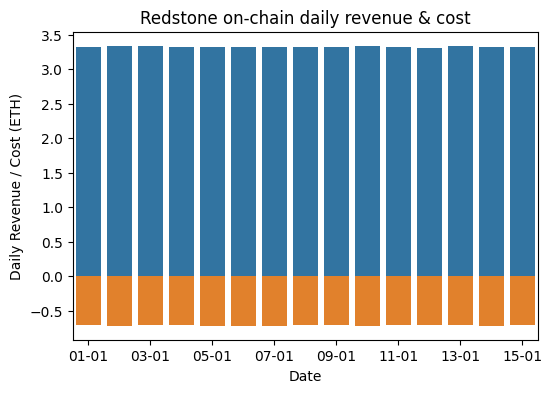

In [12]:
temp_df = agg_mc_df.copy()
temp_df["revenue_eth"] = temp_df["revenue_eth"]
temp_df["onchain_cost_eth"] = -temp_df["onchain_cost_eth"]

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(temp_df, x="timestamp", y="revenue_eth", estimator="mean", errorbar=None)
sns.barplot(temp_df, x="timestamp", y="onchain_cost_eth", estimator="mean", errorbar=None)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel("Date")
plt.ylabel("Daily Revenue / Cost (ETH)")
plt.title("Redstone on-chain daily revenue & cost")
plt.show()

In [13]:
temp_df = (
    agg_mc_df
    [["revenue_data_eth", "revenue_exec_eth", "batcher_gas_cost_eth", "proposer_gas_cost_eth", "da_gas_cost_eth"]]
    .agg(["mean", "std"])
    .T
)
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,coef_var
revenue_data_eth,3.261177,0.096834,0.03
revenue_exec_eth,0.066128,0.003071,0.05
batcher_gas_cost_eth,0.644564,0.014607,0.02
proposer_gas_cost_eth,0.058593,0.006717,0.11
da_gas_cost_eth,0.013194,0.018557,1.41


## High DA challenges?

What if we experience a higher DA challenge rate?

In [14]:
sim_len = int(15 * 60 * 60 * 24 / 12)  # 15 day of ETH blocks
sim_iter = 100  # MC paths

params = Params()
params.set_default_params()
params.set_param("da_chalenge_p", 0.0007*100) # 100x more DA challenges

In [15]:
mc_df = run_mc_sim(sim_len, sim_iter, params)
agg_mc_df = compute_output_aggregate(mc_df, "D", ["iter"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s]


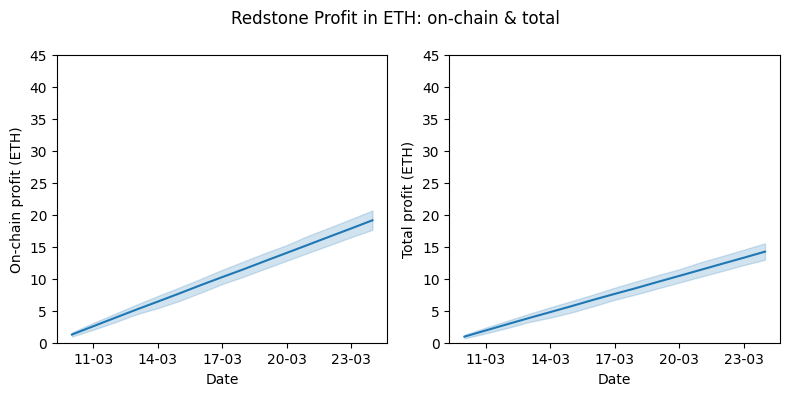

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
sns.lineplot(data=agg_mc_df, x="timestamp", y="onchain_profit_eth", errorbar="pi", ax=axs[0])
axs[0].set_xlabel("Date") 
axs[0].set_ylabel("On-chain profit (ETH)") 
axs[0].set_ylim(0,45)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=3))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
sns.lineplot(data=agg_mc_df, x="timestamp", y="total_profit_eth", errorbar="pi", ax=axs[1])
axs[1].set_xlabel("Date") 
axs[1].set_ylabel("Total profit (ETH)") 
axs[1].set_ylim(0,45)
plt.suptitle("Redstone Profit in ETH: on-chain & total")
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=3))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.tight_layout()
plt.show()

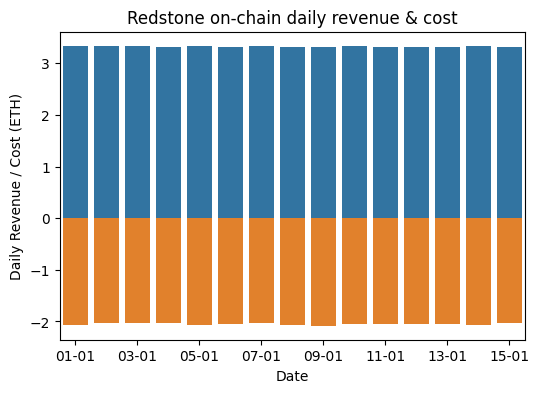

In [17]:
temp_df = agg_mc_df.copy()
temp_df["revenue_eth"] = temp_df["revenue_eth"]
temp_df["onchain_cost_eth"] = -temp_df["onchain_cost_eth"]

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(temp_df, x="timestamp", y="revenue_eth", estimator="mean", errorbar=None)
sns.barplot(temp_df, x="timestamp", y="onchain_cost_eth", estimator="mean", errorbar=None)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel("Date")
plt.ylabel("Daily Revenue / Cost (ETH)")
plt.title("Redstone on-chain daily revenue & cost")
plt.show()

**Revenue and Costs in Million ETH:**

In [18]:
temp_df = (
    agg_mc_df
    [["revenue_data_eth", "revenue_exec_eth", "batcher_gas_cost_eth", "proposer_gas_cost_eth", "da_gas_cost_eth"]]
    .agg(["mean", "std"])
    .T
)
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,coef_var
revenue_data_eth,3.258493,0.093995,0.03
revenue_exec_eth,0.066127,0.002986,0.05
batcher_gas_cost_eth,0.644426,0.014494,0.02
proposer_gas_cost_eth,0.058587,0.006588,0.11
da_gas_cost_eth,1.347052,0.184482,0.14


## Low gas usage?

What if we experience lower gas usage?

In [19]:
sim_len = int(15 * 60 * 60 * 24 / 12)  # 15 day of ETH blocks
sim_iter = 100  # MC paths

params = Params()
params.set_default_params()

# half usage
params.set_param("gas_use_low_threshold", 350000/2)
params.set_param("gas_use_low_mu", 301000/2)
params.set_param("gas_use_high_loc", 0.35 * 1000000/2)

In [20]:
mc_df = run_mc_sim(sim_len, sim_iter, params)
agg_mc_df = compute_output_aggregate(mc_df, "D", ["iter"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.48it/s]


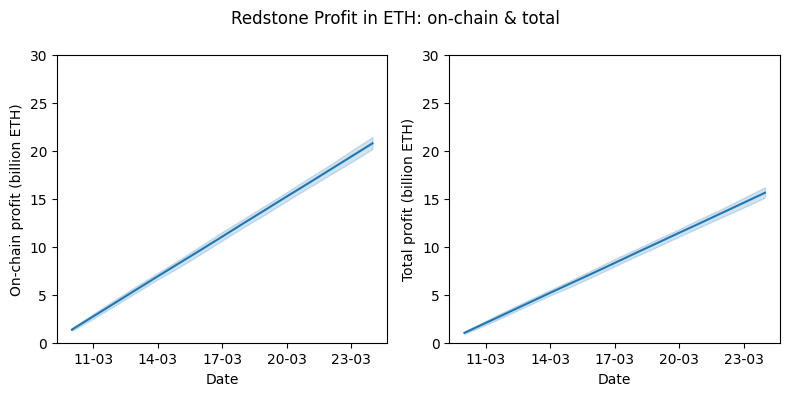

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
sns.lineplot(data=agg_mc_df, x="timestamp", y="onchain_profit_eth", errorbar="pi", ax=axs[0])
axs[0].set_xlabel("Date") 
axs[0].set_ylabel("On-chain profit (billion ETH)") 
axs[0].set_ylim(0,30)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=3))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
sns.lineplot(data=agg_mc_df, x="timestamp", y="total_profit_eth", errorbar="pi", ax=axs[1])
axs[1].set_xlabel("Date") 
axs[1].set_ylabel("Total profit (billion ETH)") 
axs[1].set_ylim(0,30)
plt.suptitle("Redstone Profit in ETH: on-chain & total")
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=3))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.tight_layout()
plt.show()

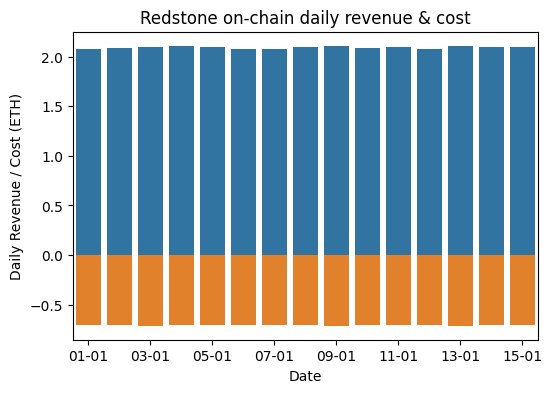

In [22]:
temp_df = agg_mc_df.copy()
temp_df["revenue_eth"] = temp_df["revenue_eth"]
temp_df["onchain_cost_eth"] = -temp_df["onchain_cost_eth"]

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(temp_df, x="timestamp", y="revenue_eth", estimator="mean", errorbar=None)
sns.barplot(temp_df, x="timestamp", y="onchain_cost_eth", estimator="mean", errorbar=None)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel("Date")
plt.ylabel("Daily Revenue / Cost (ETH)")
plt.title("Redstone on-chain daily revenue & cost")
plt.show()

In [23]:
temp_df = (
    agg_mc_df
    [["revenue_data_eth", "revenue_exec_eth", "batcher_gas_cost_eth", "proposer_gas_cost_eth", "da_gas_cost_eth"]]
    .agg(["mean", "std"])
    .T
)
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,coef_var
revenue_data_eth,2.049616,0.093875,0.05
revenue_exec_eth,0.041270,0.003093,0.07
batcher_gas_cost_eth,0.635971,0.013782,0.02
proposer_gas_cost_eth,0.058553,0.006840,0.12
da_gas_cost_eth,0.012821,0.018095,1.41
